In [1]:
import torch

# Check if MPS is available
print("MPS available:", torch.backends.mps.is_available())

# Check if MPS is built
print("MPS built:", torch.backends.mps.is_built())

# Check current device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Current device:", device)

MPS available: True
MPS built: True
Current device: mps


<h4> # Import all modules

In [2]:
from data_loader import load_images, split_data
from preprocessing import preprocess_all_images,expand_channels_for_split,get_augmentation_transform,show_random_clahe_images_per_label,preprocess_image_cv2
from dataset import MergedImagesDataset
from model import get_resnet18_model,get_resnet18_model_layer_added, get_mobilenetv2_model,get_mobilenetv2_model_layer_added,get_efficientnetb0_model_layer_added,get_efficientnetv2_s_model_layer_added
from train import train_model_with_val
from evaluate import evaluate_model, plot_training_curves
from utils import EarlyStoppingWithLR, save_best_model_state
from grad_cam import show_grad_cam_for_random_images_per_label
import mlflow
from torchinfo import summary
import torch

<h4> Mlflow Set Tracking Server <h4>

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Blade_Surface_Defect_Detection")

<Experiment: artifact_location='mlflow-artifacts:/391082854141916189', creation_time=1756969234152, experiment_id='391082854141916189', last_update_time=1756969234152, lifecycle_stage='active', name='Blade_Surface_Defect_Detection', tags={}>

<h4> # 1. Load images and labels <h4>

Loaded 400 images with 3 unique labels using cv2
Image count per label:
  Nick: 48
  Scratch: 149
  Good: 203


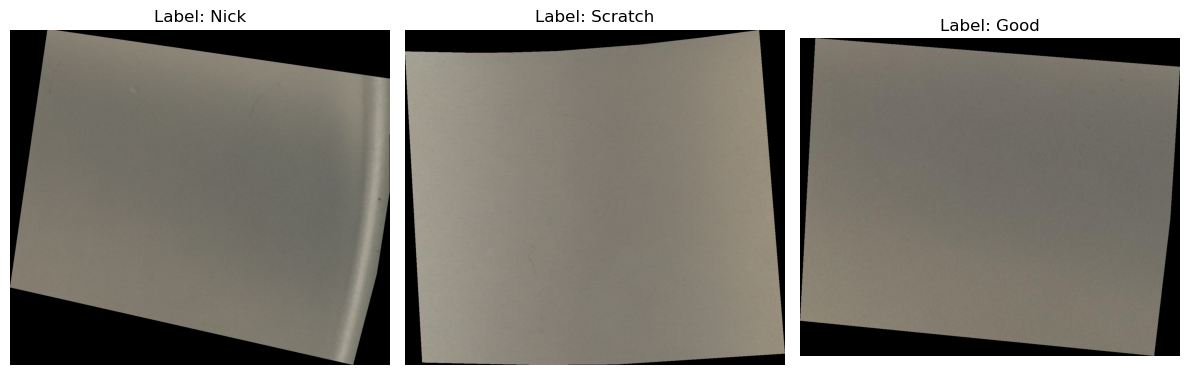

In [4]:
images, labels = load_images()
#labels = ['Good' if l == 'Good' else 'Defective' for l in labels] ## Binary mapping


<h4> # 2. Preprocess images <h4>

In [5]:
clahe_images = preprocess_all_images(images)

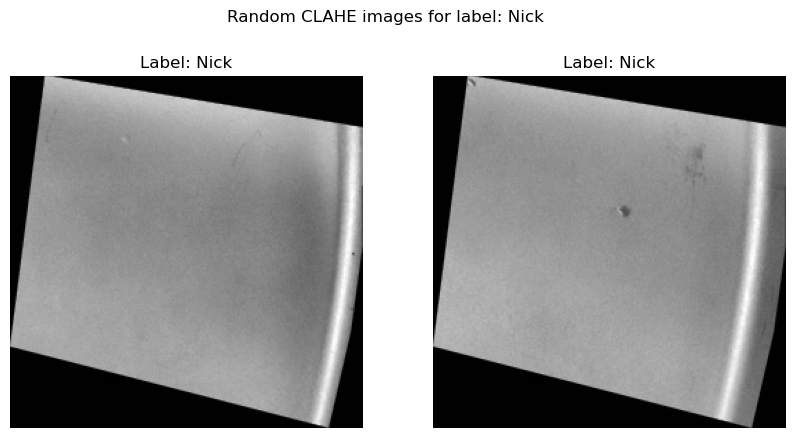

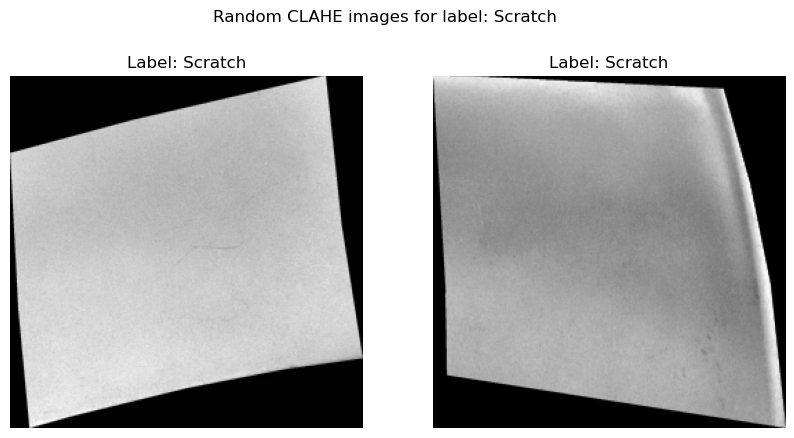

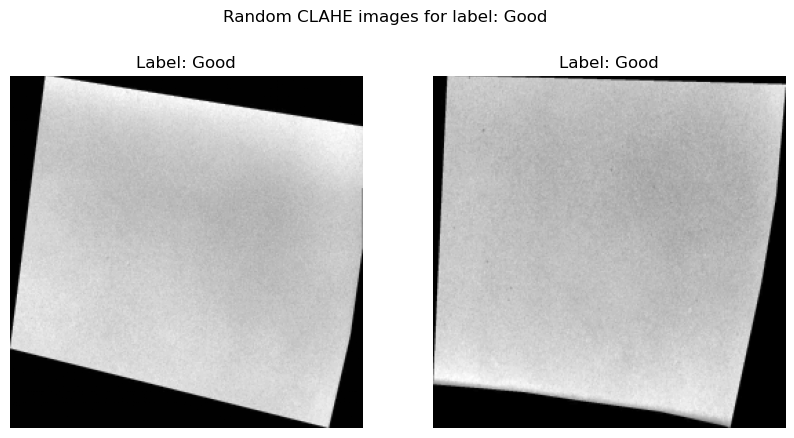

In [6]:
show_random_clahe_images_per_label(clahe_images, labels, n_per_label=2)

<h4> # 3. Split data. <h4>

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(list(clahe_images),labels)

Train: 280, Validation: 60, Test: 60


<h4> # 4. Expand channels for compatibility with pretrained models <h4>

In [8]:
x_train_exp, x_val_exp, x_test_exp = expand_channels_for_split(x_train, x_val, x_test)

<h4> # 5. Prepare label mapping <h4>

In [9]:
unique_labels = sorted(set(labels))
label_to_idx = {label: idx for idx , label in enumerate(unique_labels)}

<h4> # 6. Data augmentation <h4>

In [10]:
transform = get_augmentation_transform()

<h4> Parameters <h4>

In [11]:
num_epochs=50
lr_rate=1e-4
batch_size=32

<h4> # 7. Create datasets and dataloaders

In [12]:
train_dataset = MergedImagesDataset(x_train_exp, y_train, label_to_idx, transform=transform)
val_dataset = MergedImagesDataset(x_val_exp, y_val, label_to_idx)
test_dataset = MergedImagesDataset(x_test_exp, y_test, label_to_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


<h4> # 8. Model, loss, optimizer, scheduler <h4>

In [13]:
device = torch.device('mps')
num_classes = len(unique_labels)
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr_rate, weight_decay=1e-5)
early_stopper = EarlyStoppingWithLR(optimizer, patience=4, lr_patience=2, factor=0.7)


<h4> # 9. Train <h4>


In [14]:
with mlflow.start_run() as run:
    
    params ={
        "epoch":num_epochs,
        "lr_rate":lr_rate,
        "batch_size":batch_size,
        "loss_function":criterion,
    }
    
    mlflow.log_params(params)
    
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    loss_history, acc_history, val_loss_history, val_acc_history = train_model_with_val(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopper=early_stopper
    )
    save_best_model_state(early_stopper.best_state, "models/best_model_4.pth")
    model_info = mlflow.pytorch.log_model(model, name="model")

Epoch 1/50 - Loss: 1.0664 - Acc: 0.4571 | Val Loss: 1.1248 - Val Acc: 0.1167
Epoch 2/50 - Loss: 0.9585 - Acc: 0.6179 | Val Loss: 1.0158 - Val Acc: 0.7167
Epoch 3/50 - Loss: 0.8398 - Acc: 0.6786 | Val Loss: 0.9089 - Val Acc: 0.5833
Epoch 4/50 - Loss: 0.7326 - Acc: 0.7286 | Val Loss: 0.9457 - Val Acc: 0.4500
Epoch 5/50 - Loss: 0.6227 - Acc: 0.7607 | Val Loss: 0.7248 - Val Acc: 0.6667
Epoch 6/50 - Loss: 0.5615 - Acc: 0.7893 | Val Loss: 0.3898 - Val Acc: 0.8667
Epoch 7/50 - Loss: 0.4268 - Acc: 0.8250 | Val Loss: 0.3238 - Val Acc: 0.9000
Epoch 8/50 - Loss: 0.3672 - Acc: 0.8536 | Val Loss: 0.2668 - Val Acc: 0.9000
Epoch 9/50 - Loss: 0.3832 - Acc: 0.8250 | Val Loss: 0.2691 - Val Acc: 0.8833
Epoch 10/50 - Loss: 0.3050 - Acc: 0.8929 | Val Loss: 0.2759 - Val Acc: 0.8833
Reducing learning rate: 1.00e-04 -> 7.00e-05
Epoch 11/50 - Loss: 0.2606 - Acc: 0.9357 | Val Loss: 0.2208 - Val Acc: 0.8833
Epoch 12/50 - Loss: 0.2861 - Acc: 0.9107 | Val Loss: 0.2641 - Val Acc: 0.8833
Epoch 13/50 - Loss: 0.2322 -

2025/09/04 10:06:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run wistful-goose-90 at: http://127.0.0.1:8080/#/experiments/391082854141916189/runs/5013dc4f1ec84ea59279560c8e9e75b2
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/391082854141916189


<h4> # 10. Evaluate <h4>

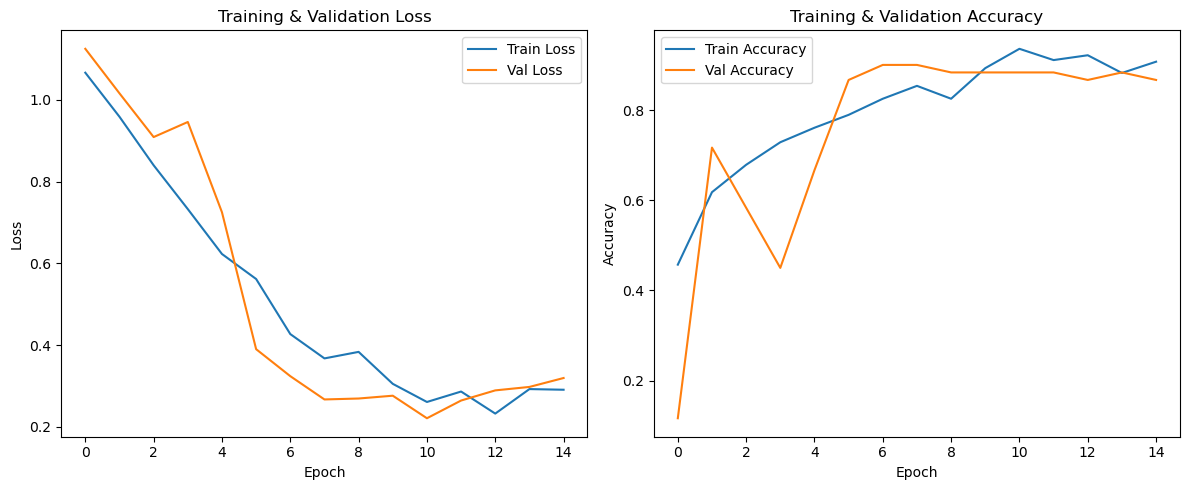

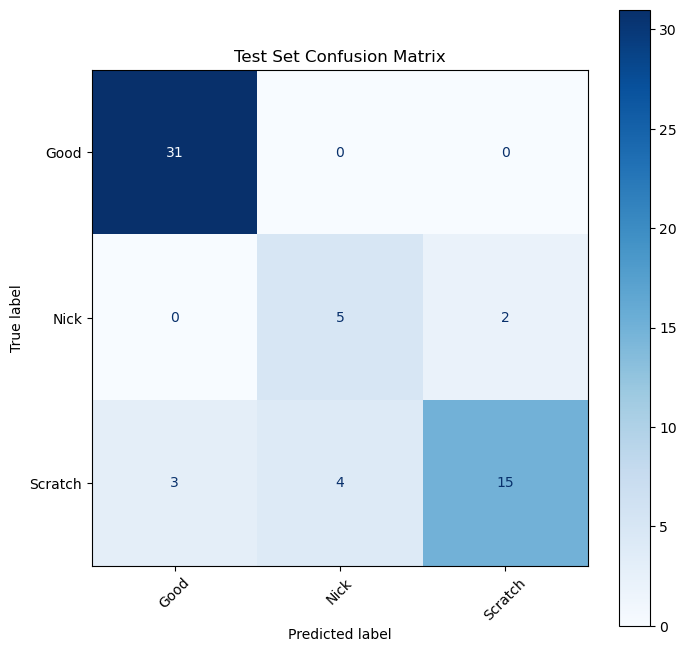

Classification Report:

              precision    recall  f1-score   support

        Good      0.912     1.000     0.954        31
        Nick      0.556     0.714     0.625         7
     Scratch      0.882     0.682     0.769        22

    accuracy                          0.850        60
   macro avg      0.783     0.799     0.783        60
weighted avg      0.859     0.850     0.848        60



In [15]:
plot_training_curves(loss_history, acc_history, val_loss_history, val_acc_history)
evaluate_model(model, test_loader, device, unique_labels)

<h4> # 11 Grad-Cam <h4>

Processing label: Good, number of images: 31


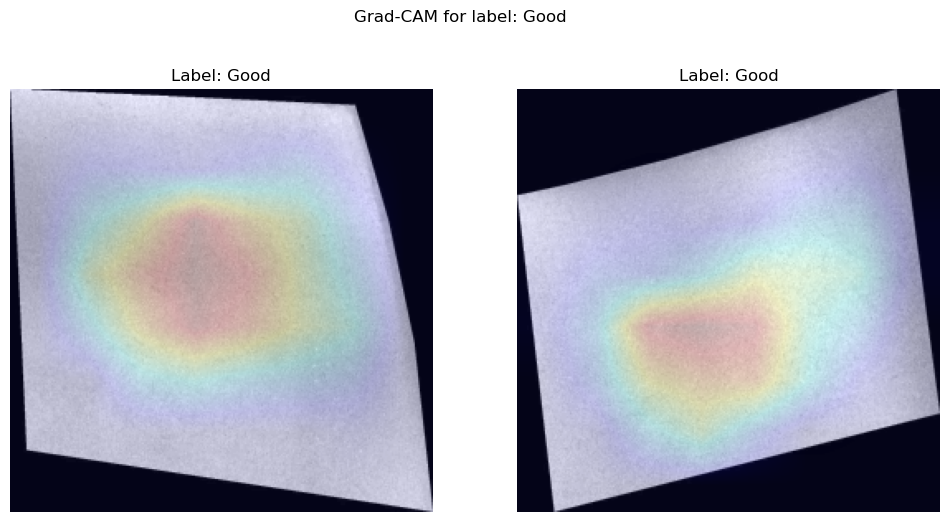

Processing label: Nick, number of images: 7


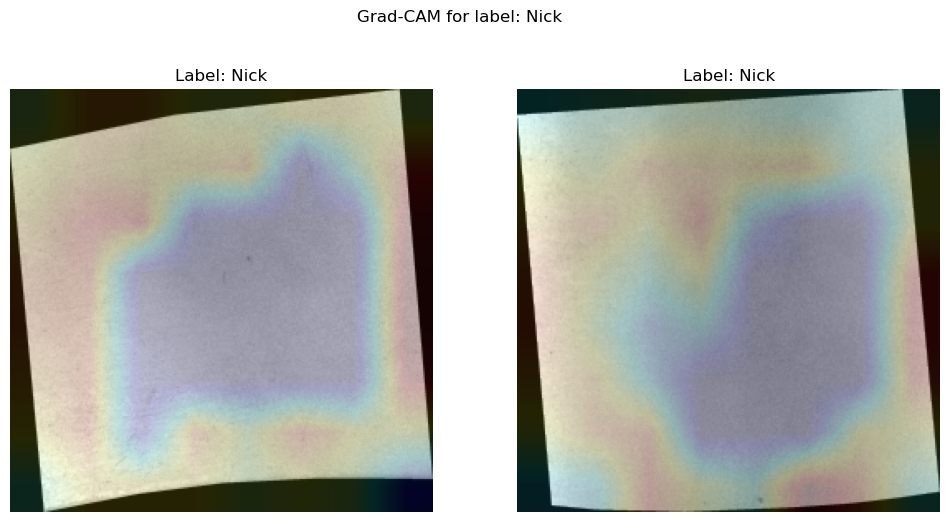

Processing label: Scratch, number of images: 22


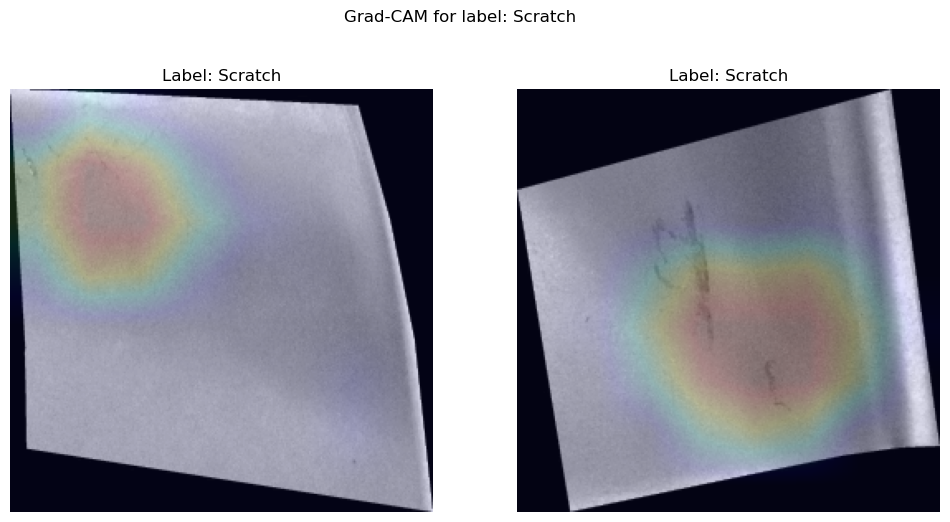

In [16]:
# Grad-CAM visualization for 2 random images per label (using numpy arrays)
num_classes = len(unique_labels)  # or the correct number for your task
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False)
model.load_state_dict(torch.load("models/best_model.pth", map_location=device))
model.to(device)
model.eval()
show_grad_cam_for_random_images_per_label(model, test_dataset, labels, label_to_idx, device, n_per_label=2)

# Debug model predictions for Scratch images in the test set only if debug is True
debug = False
if debug:
    import torch.nn.functional as F

    # Find indices of Nick images in the test set
    nick_indices_test = [i for i, l in enumerate(y_test) if l == "Nick"]

    for idx in nick_indices_test:  # Check all Nick images in test set
        img_array = x_test_exp[idx]
        # Preprocess as in grad-cam
        from torchvision import transforms
        input_tensor = transforms.Compose([
            transforms.ToTensor(),
        ])(img_array).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            probs = F.softmax(output, dim=1)
            pred_class = torch.argmax(probs).item()
            pred_label = unique_labels[pred_class]
            print(f"Test idx: {idx}, True label: Scratch, Predicted class: {pred_class} ({pred_label}), Probabilities: {probs.cpu().numpy()}")

    evaluate_model(model, test_loader, device, unique_labels)